# *This file allows to generate all plots necessary for figures*

# **Useful packages and functions**

In [54]:
using DifferentialEquations, Plots, Polynomials, LaTeXStrings, ColorSchemes, DelimitedFiles, GraphPlot
using Statistics, StatsPlots, Random, ProgressMeter, Printf, LinearAlgebra, SimpleWeightedGraphs, Compose
include("FYON_2022_DA_kinetics.jl") # Loading of DA kinetics of gating variables
include("FYON_2022_DA_models.jl") # Loading of DA model
include("FYON_2022_DA_utils.jl") # Loading of some utils functions
include("FYON_2022_DA_gs_derivatives.jl") # Loading of X_inf derivatives
include("FYON_2022_DA_DIC.jl") # Loading of the DIC and compensation algorithm
include("FYON_2022_DA_neuromodulation.jl"); # Loading of the neuromodulation cells functions

# **Global variables**

In [2]:
# Definition of simulation time (in ms)
const Tfinal = 10000
const tspan  = (0.0, Tfinal)

# Definition of reversal potential values (in mV), [Mg] and membrane capacitance
const VNa   = 60. # Sodium reversal potential
const VK    = -85. # Potassium reversal potential
const VCa   = 60. # Calcium reversal potential
const VNMDA = 0. # NMDA reversal potential
const Vleak = -50. # Reversal potential of leak channels
const Mg    = 1.4 # Mg concentration
const C     = 1. # Membrane capacitance

# Definition of voltage range for the DICs
const Vmin = -60 
const Vmax = 0
const V    = range(Vmin, stop=Vmax, step=0.01)

# Definition of the number of cells in the random set
const ncells = 200

struct eig
           values
           vectors
       end

default(fmt = :png);

In [3]:
# Defining colors
myCompleteBlue = RGB{Float64}(0. / 255., 125. / 255., 197. / 255.)
myDICBlue = RGB{Float64}(0. / 255., 119. / 255., 182. / 255.)
myLeakBlue = RGB{Float64}(131. / 255., 174. / 255., 218. / 255.);

# **Computing pairwise correlations of low frequency spiking neurons using Monte Carlo dataset (Figure 1)**

In [4]:
# Initializing some variables
Na_max = 60
Kd_max = 20
CaL_max = 0.1
CaN_max = 0.12
ERG_max = 0.25
leak_max = 0.02
N = 4e5
VV_maxmax = 58.5
VV_maxmin = 54
VV_minmin = -80.5
VV_minmax = -77.5
f_max = 1.95
f_min = 1.75
nb_channels = 6

g_all_MC = readdlm("./data/g_all_MC.dat")

# Initializing some variables
g_all_MC_wout_NMDA = zeros(ncells, nb_channels)

# Removing NMDA channels from the PCA analysis since it is constant
j = 1
for i in [1, 2, 3, 4, 5, 7]
    g_all_MC_wout_NMDA[:, j] = deepcopy(g_all_MC[:, i])
    j = j + 1
end

names = [L"\bar{g}_\mathrm{Na}", L"\bar{g}_\mathrm{Kd}", L"\bar{g}_\mathrm{CaL}", 
         L"\bar{g}_\mathrm{CaN}", L"\bar{g}_\mathrm{ERG}", L"g_\mathrm{leak}"]
maxs = [Na_max, Kd_max, CaL_max, CaN_max, ERG_max, leak_max];

3×3 Matrix{Float64}:
 0.672703  NaN         NaN
 0.311166   -0.328074  NaN
 0.610253    0.211232    0.51359

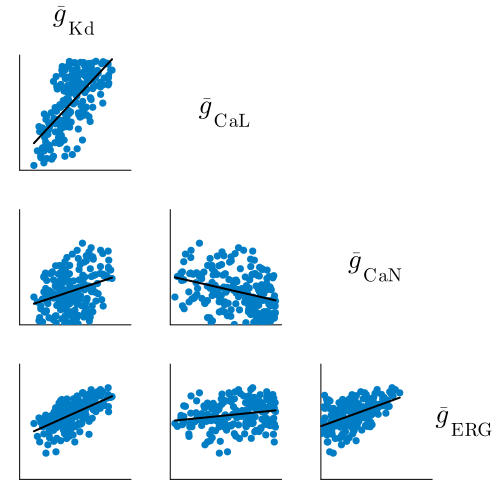

In [5]:
indices = [2, 3, 4, 5]
p1a = scatter_matrix3x3(g_all_MC_wout_NMDA[:, indices], maxs[indices], myCompleteBlue, :none, names[indices], 
                       flag=0)
display(p1a)
# savefig(p1a, "./figures/DA_MC_matrix3x3_corr.pdf")

In [6]:
nb_edges = Int(nb_channels * (nb_channels-1) / 2)
r_values = zeros(nb_edges)
i1 = 1
i2 = 2
for i = 1 : nb_edges
    r_values[i] = cor(g_all_MC_wout_NMDA[:, i1], g_all_MC_wout_NMDA[:, i2])
    if abs(r_values[i]) < 1/nb_channels
        r_values[i] = 0.0
    end
    if i2 == i1 + 1
        i1 = 1
        i2 = i2 + 1
    else
        i1 = i1 + 1
    end
end

mysalmon = colorant"rgb(243, 124, 130)"
myblue = colorant"rgb(131, 174, 218)"
coloredges = [mysalmon for i = 1 : nb_edges]
for i = 1 : nb_edges
    if r_values[i] < 0
        coloredges[i] = myblue
    end
end

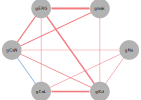

In [7]:
A = ones(nb_channels, nb_channels)
for i = 1 : nb_channels
    A[i, i] = 0
end
AA = convert(Array{Int64}, A)
GG = SimpleWeightedGraph(AA)
nodecolors=[RGB(0.7,0.7,0.7) for i=1:nb_channels]
nodelabel = ["gNa", "gKd", "gCaL", "gCaN", "gERG", "gleak"]

p1b = gplot(GG, layout=circular_layout, nodefillc=nodecolors, nodelabel=nodelabel, NODESIZE=0.175,
              edgelinewidth=abs.(r_values), EDGELINEWIDTH=2, edgestrokec=coloredges)
display(p1b)
# draw(SVG("./figures/DA_graph_corr.svg", 16cm, 16cm), p1b);

In [8]:
# Initializing some variables
Rin_spiking_MC = zeros(ncells)
V_Rin = -55.5

# Looping over all points to compute input resistance at threshold voltage
for i = 1 : ncells
    Rin_spiking_MC[i] = (g_all_MC[i, 1]*m_inf(V_Rin)^3*h_inf(V_Rin) + 
                           g_all_MC[i, 2]*n_inf(V_Rin)^3 + 
                           g_all_MC[i, 3]*mCaL_inf(V_Rin)^2 + 
                           g_all_MC[i, 4]*mCaN_inf(V_Rin) +
                           g_all_MC[i, 5]*o_inf(V_Rin) +
                           g_all_MC[i, 6]*NMDA_inf(V_Rin) +
                           g_all_MC[i, 7])^(-1)
end

g_all_MC_wout_NMDA_normalized = deepcopy(g_all_MC_wout_NMDA)
for i = 1 : ncells
    g_all_MC_wout_NMDA_normalized[i, :] = g_all_MC_wout_NMDA_normalized[i, :] .* Rin_spiking_MC[i]
    #g_all_MC_wout_NMDA_normalized[i, :] = g_all_MC_wout_NMDA_normalized[i, :] ./ g_all_MC_wout_NMDA[i, end]
end

3×3 Matrix{Float64}:
  0.680698   NaN         NaN
 -0.0208901   -0.566504  NaN
  0.192287    -0.130442    0.150692

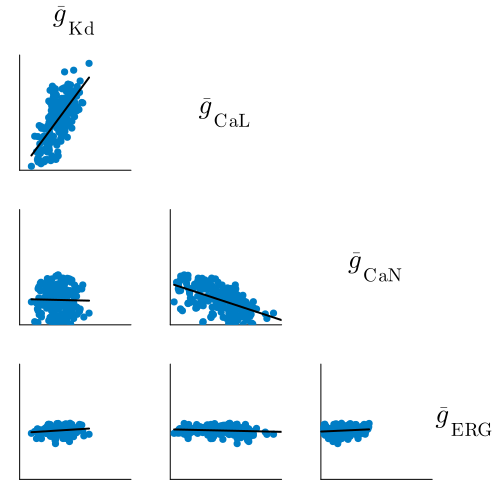

In [9]:
indices = [2, 3, 4, 5]
p4c = scatter_matrix3x3(g_all_MC_wout_NMDA_normalized[:, indices], maxs[indices]*30, 
                        myCompleteBlue, :none, 
                        names[indices], flag=0)
display(p4c)
# savefig(p4b, "./figures/DA_spiking_norm_matrix3x3_PC12.pdf")

# **Computing PCA of low frequency spiking neurons using Monte Carlo dataset (Figure 2)**

In [10]:
# Means on spiking point cloud
mean_MC = zeros(1, nb_channels)
mean!(mean_MC, g_all_MC_wout_NMDA)

# Defining scaling factors and limits for the plots
s1 = 2
s2 = 2

# Normalizing data before applying PCA
g_all_MC_norm = deepcopy(g_all_MC_wout_NMDA)
for i = 1 : nb_channels
    g_all_MC_norm[:, i] = g_all_MC_wout_NMDA[:, i] / std(g_all_MC_wout_NMDA[:, i])
end

# PCA on spiking point cloud
cov_matrix_MC = cov(g_all_MC_norm)
eig_MC = eigen(cov_matrix_MC, sortby = x -> abs(x))

# Computing PCA components to map back to the non-normalized dataset
eig_MC_plot = deepcopy(eig_MC)
for i = 1 : nb_channels
    eig_MC_plot.vectors[i, :] = eig_MC_plot.vectors[i, :] *
                                        std(g_all_MC_wout_NMDA[:, i])
end

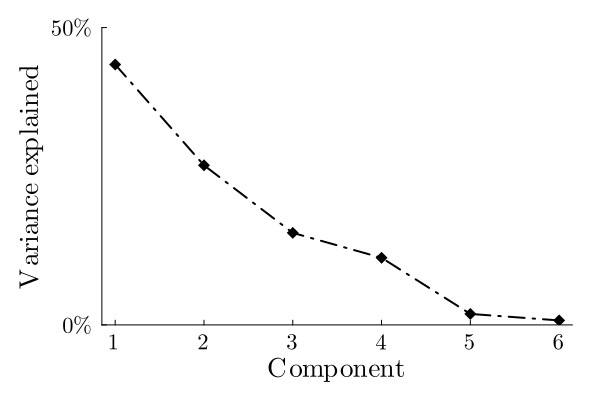

In [11]:
total_var = sum(eig_MC.values)
eig_val_decreasing = reverse(eig_MC.values) ./ total_var

p2a  = plot(eig_val_decreasing, label="", grid=false, guidefontsize=18, markershape=:diamond, 
            linestyle=:dashdot, legendfontsize=12, margin=5Plots.mm, 
            xticks=([1, 2, 3, 4, 5, 6, 7, 8], [L"1", L"2", L"3", L"4", L"5", L"6", L"7", L"8"]), 
            color=:black, markersize=6, linewidth=2, tickfontsize=15,
            yticks=([0, 0.5], [L"0\%", L"50\%"]), size=(600, 400))

ylims!((0., 0.5))
xlabel!(L"\mathrm{Component}")
ylabel!(L"\mathrm{Variance}\,\,\mathrm{explained}")
display(p2a)
# savefig(p2a, "./figures/DA_MC_scree_shuffle.pdf")

In [12]:
important_PCA = 0

expl_var = 0.
while(expl_var < 0.8)
    important_PCA = important_PCA + 1
    expl_var = expl_var + eig_val_decreasing[important_PCA]
end
display(important_PCA)

3

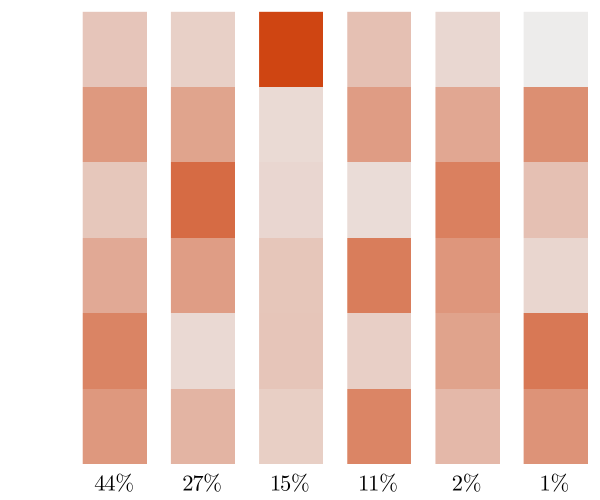

In [13]:
p2b = heatmap_dir(eig_MC, nb_channels)
display(p2b)
# savefig(p2b, "./figures/DA_MC_eig_vectors.pdf")

# **Comparing PC1 of low frequency spiking neurons using Monte Carlo dataset to homogeneous scaling (Figure 3)**

In [56]:
PC1_abs = abs.(eig_MC.vectors[:, nb_channels]) ./ 
        norm(eig_MC.vectors[:, nb_channels])
best_four = sortperm(PC1_abs, rev=true)[1:4];

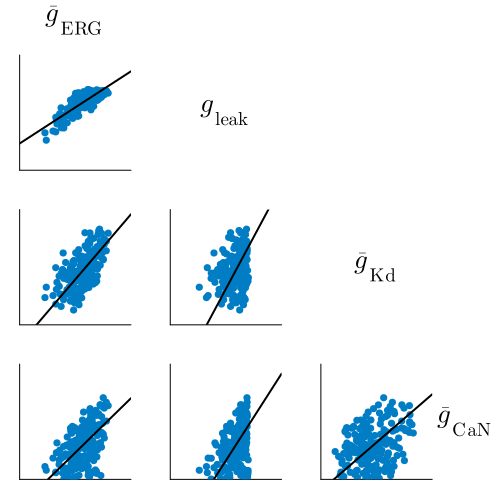

In [57]:
dir_val = eig(eig_MC_plot.values[end],  eig_MC_plot.vectors[best_four, :])
CC = scatter_matrix3x3(g_all_MC_wout_NMDA[:, best_four], maxs[best_four], myCompleteBlue, :none, names[best_four], 
                       flag=1, dir_val=dir_val, mean_vec=mean_MC[best_four], s1=1000)
display(CC)
# savefig(CC, "./figures/DA_MC_matrix3x3_PC1.pdf")

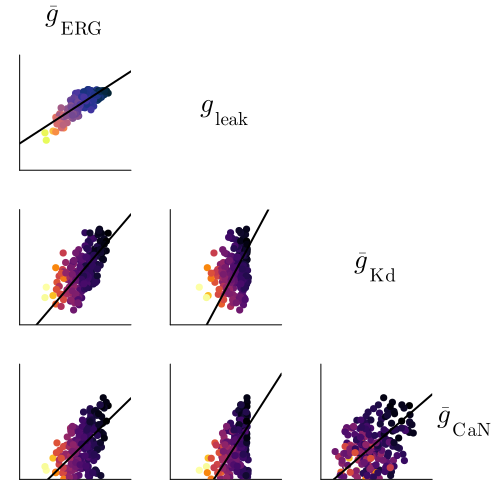

In [58]:
dir_val = eig(eig_MC_plot.values[end],  eig_MC_plot.vectors[best_four, :])
CC = scatter_matrix3x3_zcolor(g_all_MC_wout_NMDA[:, best_four], maxs[best_four], Rin_spiking_MC, :none, names[best_four], 
                       flag=1, dir_val=dir_val, mean_vec=mean_MC[best_four], s1=1000)
display(CC)
# savefig(CC, "./figures/DA_MC_matrix3x3_PC1.pdf")

In [16]:
function angle_between_vectors(u, v)
    dot_prod = dot(u, v)
    norm_u = norm(u)
    norm_v = norm(v)
    angle = acosd(dot_prod / (norm_u * norm_v))
    return angle
end

PC1 = -eig_MC.vectors[:, nb_channels]
homo_scaling = deepcopy(vec(mean_MC))
for i = 1 : nb_channels
    homo_scaling[i] = homo_scaling[i] / std(g_all_MC_wout_NMDA[:, i])
end

display(angle_between_vectors(PC1, homo_scaling))
display(cosd(angle_between_vectors(PC1, homo_scaling)))

26.93935589135274

0.8914865464216547

# **Interpreting other PCs of low frequency spiking neurons using custom dataset to zero sensitivity direction of slow dynamical properties of the membrane (Figure 4)**

In [17]:
g_all_spiking = readdlm("./data/g_all_spiking.dat")
g_all_spiking_DIC = readdlm("./data/g_all_spiking_DIC.dat")
g_all_spiking_leak = readdlm("./data/g_all_spiking_leak.dat")

g_all_triplets = readdlm("./data/g_all_triplets.dat")
g_all_triplets_DIC = readdlm("./data/g_all_triplets_DIC.dat")
g_all_triplets_leak = readdlm("./data/g_all_triplets_leak.dat")

g_all_bursting = readdlm("./data/g_all_bursting.dat")
g_all_bursting_DIC = readdlm("./data/g_all_bursting_DIC.dat")
g_all_bursting_leak = readdlm("./data/g_all_bursting_leak.dat")

const ncells = 500;

In [18]:
# Initializing some variables
g_all_spiking_wout_NMDA = zeros(ncells, nb_channels)

# Removing NMDA channels from the PCA analysis since it is constant
j = 1
for i in [1, 2, 3, 4, 5, 7]
    g_all_spiking_wout_NMDA[:, j] = deepcopy(g_all_spiking[:, i])
    j = j + 1
end

# Means on spiking point cloud
mean_spiking = zeros(1, nb_channels)
mean!(mean_spiking, g_all_spiking_wout_NMDA)

# Defining scaling factors and limits for the plots
s1 = 1.8
s2 = 1.3
Na_max = 60
Kd_max = 20
CaL_max = 0.1
CaN_max = 0.3
ERG_max = 0.25
leak_max = 0.02

# Normalizing data before applying PCA
g_all_spiking_norm = deepcopy(g_all_spiking_wout_NMDA)
for i = 1 : nb_channels
    g_all_spiking_norm[:, i] = g_all_spiking_wout_NMDA[:, i] / std(g_all_spiking_wout_NMDA[:, i])
end

# PCA on spiking point cloud
cov_matrix_spiking = cov(g_all_spiking_norm)
eig_spiking = eigen(cov_matrix_spiking, sortby = x -> abs(x))

# Computing PCA components to map back to the non-normalized dataset
eig_spiking_plot = deepcopy(eig_spiking)
for i = 1 : nb_channels
    eig_spiking_plot.vectors[i, :] = eig_spiking_plot.vectors[i, :] *
                                        std(g_all_spiking_wout_NMDA[:, i])
end

In [19]:
# Initializing some variables
g_all_spiking_leak_wout_NMDA = zeros(ncells, nb_channels)

# Removing NMDA channels from the PCA analysis since it is constant
j = 1
for i in [1, 2, 3, 4, 5, 7]
    g_all_spiking_leak_wout_NMDA[:, j] = deepcopy(g_all_spiking_leak[:, i])
    j = j + 1
end

# Initializing some variables
g_all_spiking_DIC_wout_NMDA = zeros(ncells, nb_channels)

# Removing NMDA channels from the PCA analysis since it is constant
j = 1
for i in [1, 2, 3, 4, 5, 7]
    g_all_spiking_DIC_wout_NMDA[:, j] = deepcopy(g_all_spiking_DIC[:, i])
    j = j + 1
end

In [20]:
PC2_abs = abs.(eig_spiking.vectors[:, nb_channels-1]) ./ 
        norm(eig_spiking.vectors[:, nb_channels-1])
best_four = sortperm(PC2_abs, rev=true)[1:4];

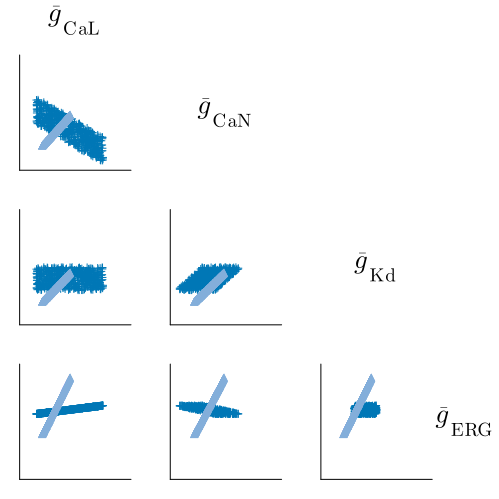

In [21]:
p4a = scatter_matrix3x3(g_all_spiking_DIC_wout_NMDA[:, best_four], maxs[best_four], myDICBlue, :cross, 
                       names[best_four], flag=3, flag2=1, 
                       g_all2=g_all_spiking_leak_wout_NMDA[:, best_four], color_p2=myLeakBlue, m_shape2=:utriangle)
display(p4a)
# savefig(p4a, "./figures/DA_spiking_matrix3x3_separated.pdf")

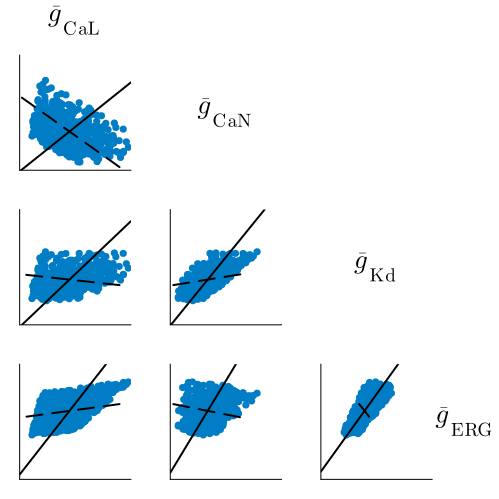

In [22]:
dir_val = eig(eig_spiking_plot.values[end],  eig_spiking_plot.vectors[best_four, :])
p4b = scatter_matrix3x3(g_all_spiking_wout_NMDA[:, best_four], maxs[best_four], myCompleteBlue, :none, 
                       names[best_four], flag=2, dir_val=dir_val, 
                       mean_vec=mean_spiking[best_four], s1=10, s2=0.8)
display(p4b)
# savefig(p4b, "./figures/DA_spiking_matrix3x3_PC12.pdf")

In [23]:
# Initializing some variables
Rin_spiking = zeros(500)
V_Rin = -55.5

# Looping over all points to compute input resistance at threshold voltage
for i = 1 : 500
    Rin_spiking[i] = (g_all_spiking[i, 1]*m_inf(V_Rin)^3*h_inf(V_Rin) + 
                           g_all_spiking[i, 2]*n_inf(V_Rin)^3 + 
                           g_all_spiking[i, 3]*mCaL_inf(V_Rin)^2 + 
                           g_all_spiking[i, 4]*mCaN_inf(V_Rin) +
                           g_all_spiking[i, 5]*o_inf(V_Rin) +
                           g_all_spiking[i, 6]*NMDA_inf(V_Rin) +
                           g_all_spiking[i, 7])^(-1)
end

g_all_spiking_wout_NMDA_normalized = deepcopy(g_all_spiking_wout_NMDA)
for i = 1 : 500
    g_all_spiking_wout_NMDA_normalized[i, :] = g_all_spiking_wout_NMDA_normalized[i, :] .* Rin_spiking[i]
    #g_all_spiking_wout_NMDA_normalized[i, :] = g_all_spiking_wout_NMDA_normalized[i, :] ./ g_all_spiking_wout_NMDA[i, end]
end

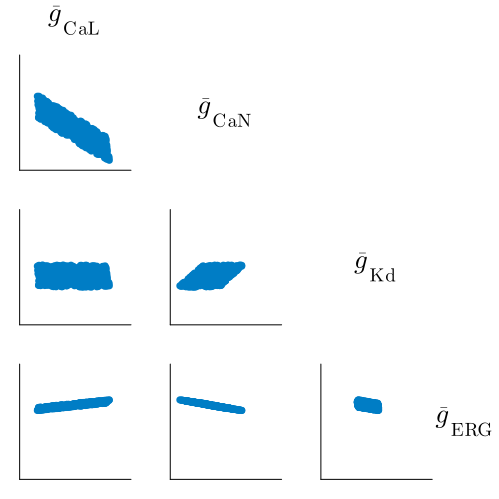

In [24]:
p4c = scatter_matrix3x3(g_all_spiking_wout_NMDA_normalized[:, best_four], maxs[best_four]*20, 
                        myCompleteBlue, :none, 
                        names[best_four], flag=3)
display(p4c)
# savefig(p4b, "./figures/DA_spiking_norm_matrix3x3_PC12.pdf")

# **Interpreting other PCs of low frequency spiking neurons using Monte Carlo dataset to zero sensitivity direction of slow dynamical properties of the membrane (Figure 5)**

In [25]:
# Extracting threshold voltage and weighting factors for a specific neuron
(gNa, gKd, gCaL, gCaN, gERG, gNMDA, gleak) = g_all_MC[1, :]
(ith, iosc, gf, gs, gu, gin, Istatic) = DICs(V, 0., gNa, gKd, gCaL, gCaN, gERG, gNMDA, gleak)
Vth = V[ith]
tau_f = tau_m(Vth)
tau_s = tau_n(Vth)
tau_u = 100. # Fixed because no tau for the ERG current
(wfs_m, wsu_m) = var_contribution(tau_m(Vth), tau_f, tau_s, tau_u)
(wfs_h, wsu_h) = var_contribution(tau_h(Vth), tau_f, tau_s, tau_u)
(wfs_n, wsu_n) = var_contribution(tau_n(Vth), tau_f, tau_s, tau_u)
(wfs_mCaL, wsu_mCaL) = var_contribution(tau_mCaL(Vth), tau_f, tau_s, tau_u)
(wfs_mCaN, wsu_mCaN) = var_contribution(tau_mCaN(Vth), tau_f, tau_s, tau_u)
wfs_oERG = 0.
wsu_oERG = 0.

# Computing derivatives of gs(Vth) with respect to maximal ion channel conductances
dgs_dNa = (wsu_m - wfs_m)*3*m_inf(Vth)^2*h_inf(Vth)*(Vth-VNa)*dm(Vth) + 
          (wsu_h - wfs_h)*m_inf(Vth)^3*(Vth-VNa)*dh(Vth)
dgs_dCaL = (wsu_mCaL - wfs_mCaL)*2*mCaL_inf(Vth)*(Vth-VCa)*dmCaL(Vth)
dgs_dCaN = (wsu_mCaN - wfs_mCaN)*(Vth-VCa)*dmCaN(Vth)
dgs_dKd = (wsu_n - wfs_n)*3*n_inf(Vth)^2*(Vth-VK)*dn(Vth)
dgs_dERG = (wsu_oERG - wfs_oERG)*(Vth-VK)*doERG(Vth);

In [26]:
# Computing angles
theta_CaLCaN_DIC = -atan((dgs_dCaL/CaN_max)/(dgs_dCaN/CaL_max))
theta_CaLCaN = atan((eig_MC_plot.vectors[:, nb_channels-1][4]/CaN_max)/
                    (eig_MC_plot.vectors[:, nb_channels-1][3]/CaL_max))

theta_KdCaL_DIC = -atan((dgs_dKd/CaL_max)/(dgs_dCaL/Kd_max))
theta_KdCaL = atan((eig_MC_plot.vectors[:, nb_channels-1][3]/CaL_max)/
                   (eig_MC_plot.vectors[:, nb_channels-1][2]/Kd_max))

theta_KdCaN_DIC = -atan((dgs_dKd/CaN_max)/(dgs_dCaN/Kd_max))
theta_KdCaN4 = atan((eig_MC_plot.vectors[:, nb_channels-3][4]/CaN_max)/
                    (eig_MC_plot.vectors[:, nb_channels-3][2]/Kd_max))

theta_NaCaL_DIC = -atan((dgs_dNa/CaL_max)/(dgs_dCaL/Na_max))
theta_NaCaL = atan((eig_MC_plot.vectors[:, nb_channels-3][3]/CaL_max)/
                    (eig_MC_plot.vectors[:, nb_channels-3][1]/Na_max));

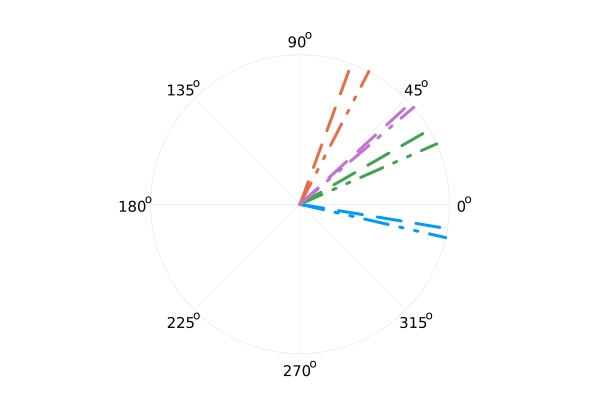

In [27]:
p5a = plot([theta_CaLCaN, theta_CaLCaN], [0, 1], proj=:polar, linewidth=3, label="", yticks=[], 
            yguidefontsize=18, xguidefontsize=18, legendfontsize=12, margin=5Plots.mm, 
            color=1, xtickfontsize=10, linestyle=:dash)
plot!([theta_CaLCaN_DIC, theta_CaLCaN_DIC], [0, 1], proj=:polar, linewidth=3, label="", 
      color=1, linestyle=:dashdotdot)
plot!([theta_KdCaL, theta_KdCaL], [0, 1], proj=:polar, linewidth=3, label="", 
      color=2, linestyle=:dash)
plot!([theta_KdCaL_DIC, theta_KdCaL_DIC], [0, 1], proj=:polar, linewidth=3, label="", 
      color=2, linestyle=:dashdotdot)
plot!([theta_KdCaN4, theta_KdCaN4], [0, 1], proj=:polar, linewidth=3, label="", 
      color=3, linestyle=:dash)
plot!([theta_KdCaN_DIC, theta_KdCaN_DIC], [0, 1], proj=:polar, linewidth=3, label="", 
      color=3, linestyle=:dashdotdot)
plot!([theta_NaCaL_DIC, theta_NaCaL_DIC], [0, 1], proj=:polar, linewidth=3, label="", 
      color=4, linestyle=:dashdotdot)
plot!([theta_NaCaL, theta_NaCaL], [0, 1], proj=:polar, linewidth=3, label="", 
      color=4, linestyle=:dash)
ylims!(0, 1)
display(p5a)
# savefig(p5a, "./figures/DA_MC_polar_DIC.pdf")

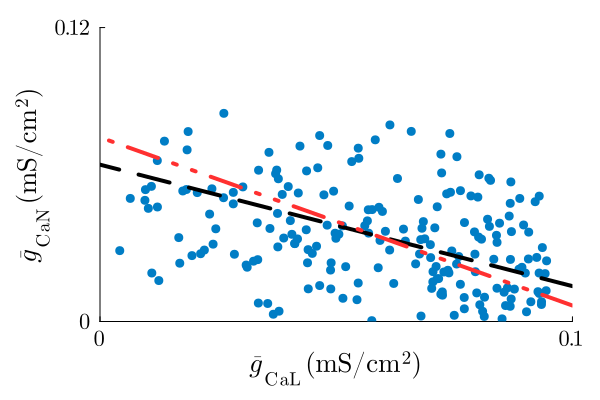

In [28]:
p5b = scatter(g_all_MC[:, 3], g_all_MC[:, 4], label="", color=myCompleteBlue, grid=false,
              yguidefontsize=18, xguidefontsize=18, legendfontsize=12, margin=5Plots.mm,
              markerstrokewidth=0., markersize=5, yticks=([0, 0.12], [L"0", L"0.12"]), tickfontsize=15, 
              xticks=([0, 0.1], [L"0", L"0.1"]), size=(600, 400))

plot!([mean_MC[3] - 1e4*eig_MC_plot.vectors[:, nb_channels-1][3]*eig_MC_plot.values[nb_channels-1], 
       mean_MC[3] + 1e4*eig_MC_plot.vectors[:, nb_channels-1][3]*eig_MC_plot.values[nb_channels-1]],
       [mean_MC[4] - 1e4*eig_MC_plot.vectors[:, nb_channels-1][4]*eig_MC_plot.values[nb_channels-1], 
       mean_MC[4] + 1e4*eig_MC_plot.vectors[:, nb_channels-1][4]*eig_MC_plot.values[nb_channels-1]],
       arrow=false, color=:black, linewidth=4, label="", linestyle=:dash)

plot!([mean_MC[3] - 10* dgs_dCaN, mean_MC[3] + 10*dgs_dCaN],
      [mean_MC[4] + 10*dgs_dCaL, mean_MC[4] - 10*dgs_dCaL],
      arrow=false, color=:firebrick1, linewidth=4, label="", linestyle=:dashdotdot)

xlabel!(L"\bar{g}_\mathrm{CaL}\,\mathrm{(mS/cm^2)}")
ylabel!(L"\bar{g}_\mathrm{CaN}\,\mathrm{(mS/cm^2)}")
xlims!((0, 0.1))
ylims!((0, 0.12))
display(p5b)
# savefig(p5b, "./figures/neuromod_gCaLCaN_MC_DIC.pdf")

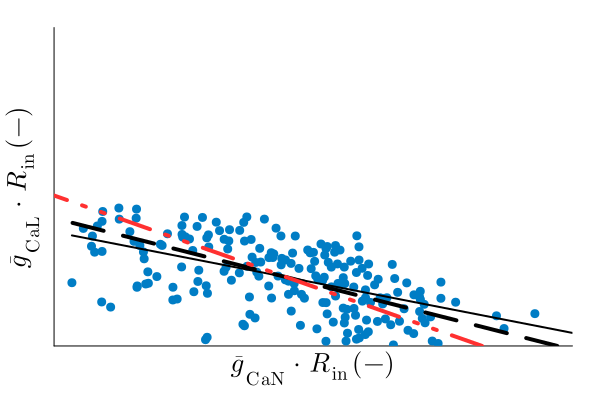

In [53]:
p5b = scatter(g_all_MC_wout_NMDA_normalized[:, 3], g_all_MC_wout_NMDA_normalized[:, 4], label="", color=myCompleteBlue, grid=false,
              yguidefontsize=18, xguidefontsize=18, legendfontsize=12, margin=5Plots.mm,
              markerstrokewidth=0., markersize=5, tickfontsize=15, yticks=false,
              xticks=false, size=(600, 400))
mean_MC_normalized = zeros(1, nb_channels)
mean!(mean_MC_normalized, g_all_MC_wout_NMDA_normalized)

line_normalized = fit(g_all_MC_wout_NMDA_normalized[:, 3], g_all_MC_wout_NMDA_normalized[:, 4], 1)
        s0 = minimum(g_all_MC_wout_NMDA_normalized[:, 3])
        sn = maximum(g_all_MC_wout_NMDA_normalized[:, 3])
        plot!([s0, sn], [line_normalized(s0), line_normalized(sn)], linewidth=2, label="", linecolor="black")

plot!([mean_MC_normalized[3] - 400*eig_MC_plot.vectors[:, nb_channels-1][3]*eig_MC_plot.values[nb_channels-1], 
      mean_MC_normalized[3] + 400*eig_MC_plot.vectors[:, nb_channels-1][3]*eig_MC_plot.values[nb_channels-1]],
      [mean_MC_normalized[4] - 400*eig_MC_plot.vectors[:, nb_channels-1][4]*eig_MC_plot.values[nb_channels-1], 
      mean_MC_normalized[4] + 400*eig_MC_plot.vectors[:, nb_channels-1][4]*eig_MC_plot.values[nb_channels-1]],
      arrow=false, color=:black, linewidth=4, label="", linestyle=:dash)

plot!([mean_MC_normalized[3] - 10* dgs_dCaN, mean_MC_normalized[3] + 10*dgs_dCaN],
      [mean_MC_normalized[4] + 10*dgs_dCaL, mean_MC_normalized[4] - 10*dgs_dCaL],
      arrow=false, color=:firebrick1, linewidth=4, label="", linestyle=:dashdotdot)

ylabel!(L"\bar{g}_\mathrm{CaL}\cdot R_\mathrm{in}\,\mathrm{(-)}")
xlabel!(L"\bar{g}_\mathrm{CaN}\cdot R_\mathrm{in}\,\mathrm{(-)}")
xlims!((0, 3))
ylims!((0, 3.6))
display(p5b)
# savefig(p5b, "./figures/neuromod_gCaSA_MC_DIC.pdf")

# **Uncovering that apparent correlation comes from two physiological mechanisms that can be interefering (Figure 6)**

In [29]:
g_all_spiking = readdlm("./data/g_all_spiking.dat")
g_all_spiking_DIC = readdlm("./data/g_all_spiking_DIC.dat")
g_all_spiking_leak = readdlm("./data/g_all_spiking_leak.dat")

# Definition of the number of cells in the random set
const ncells = 500;

In [30]:
# Number of ion channels in the DA model
nb_channels = 6

# Initializing some variables
g_all_spiking_wout_NMDA = zeros(ncells, nb_channels)

# Removing NMDA channels from the PCA analysis since it is constant
j = 1
for i in [1, 2, 3, 4, 5, 7]
    g_all_spiking_wout_NMDA[:, j] = deepcopy(g_all_spiking[:, i])
    j = j + 1
end

# Means on spiking point cloud
mean_spiking = zeros(1, nb_channels)
mean!(mean_spiking, g_all_spiking_wout_NMDA)

# Defining scaling factors and limits for the plots
s1 = 1.8
s2 = 1.3
Na_max = 60
Kd_max = 20
CaL_max = 0.1
CaN_max = 0.3
ERG_max = 0.25
leak_max = 0.02

# Normalizing data before applying PCA
g_all_spiking_norm = deepcopy(g_all_spiking_wout_NMDA)
for i = 1 : nb_channels
    g_all_spiking_norm[:, i] = g_all_spiking_wout_NMDA[:, i] / std(g_all_spiking_wout_NMDA[:, i])
end

# PCA on spiking point cloud
cov_matrix_spiking = cov(g_all_spiking_norm)
eig_spiking = eigen(cov_matrix_spiking, sortby = x -> abs(x))

# Computing PCA components to map back to the non-normalized dataset
eig_spiking_plot = deepcopy(eig_spiking)
for i = 1 : nb_channels
    eig_spiking_plot.vectors[i, :] = eig_spiking_plot.vectors[i, :] *
                                        std(g_all_spiking_wout_NMDA[:, i])
end

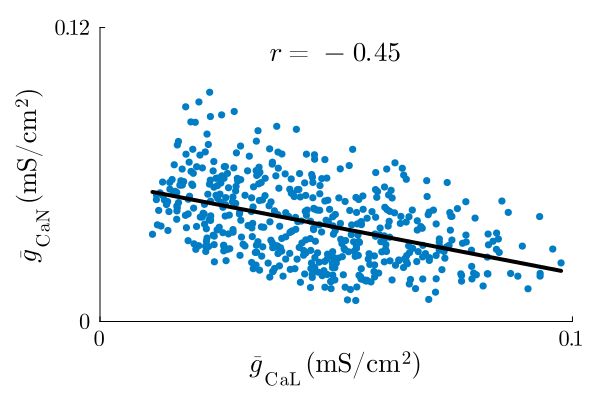

In [31]:
p6a = scatter(g_all_spiking[:, 3], g_all_spiking[:, 4], label="", color=myCompleteBlue, grid=false,
              yguidefontsize=18, xguidefontsize=18, legendfontsize=12, margin=5Plots.mm,
              markerstrokewidth=0., yticks=([0, 0.12], [L"0", L"0.12"]), tickfontsize=15, 
              xticks=([0, 0.1], [L"0", L"0.1"]), size=(600, 400))

line_34 = fit(g_all_spiking[:, 3], g_all_spiking[:, 4], 1)
s0 = minimum(g_all_spiking[:, 3])
sn = maximum(g_all_spiking[:, 3])
plot!([s0, sn], [line_34(s0), line_34(sn)], linewidth=4, label="", linecolor="black")

pearson_cor_spiking = cor(g_all_spiking[:, 3], g_all_spiking[:, 4])
str_pearson_cor_spiking = @sprintf "%.2f" pearson_cor_spiking
annotate!(0.05, 0.11, Plots.text(L"r =  %$str_pearson_cor_spiking", :black, :center, 18))

xlabel!(L"\bar{g}_\mathrm{CaL}\,\mathrm{(mS/cm^2)}")
ylabel!(L"\bar{g}_\mathrm{CaN}\,\mathrm{(mS/cm^2)}")
xlims!((0, 0.1))
ylims!((0, 0.12))
display(p6a)
# savefig(p6a, "./figures/PCA_DA_neuromod_gCaLCaN_spiking.pdf")

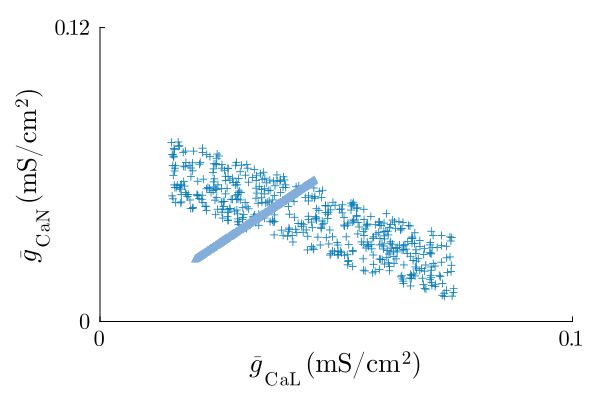

In [32]:
p6b = scatter(g_all_spiking_DIC[:, 3], g_all_spiking_DIC[:, 4], label="",
              markershape=:cross, color=myDICBlue, grid=false, yguidefontsize=18, 
              xguidefontsize=18, legendfontsize=12, margin=5Plots.mm, legend=false,
              yticks=([0, 0.12], [L"0", L"0.12"]), tickfontsize=15, 
              xticks=([0, 0.1], [L"0", L"0.1"]), size=(600, 400))
scatter!(g_all_spiking_leak[:, 3], g_all_spiking_leak[:, 4], label="", 
         color=myLeakBlue, markershape=:utriangle, markerstrokewidth=0.)

xlabel!(L"\bar{g}_\mathrm{CaL}\,\mathrm{(mS/cm^2)}")
ylabel!(L"\bar{g}_\mathrm{CaN}\,\mathrm{(mS/cm^2)}")
xlims!((0, 0.1))
ylims!((0, 0.12))
display(p6b)
# savefig(p6b, "./figures/neuromod_gCaLCaN_separation_spiking.pdf")

# **Correlations are neuromodulation dependent (Figure 7)**

In [33]:
g_all_triplets = readdlm("./data/g_all_triplets.dat")
g_all_triplets_DIC = readdlm("./data/g_all_triplets_DIC.dat")
g_all_triplets_leak = readdlm("./data/g_all_triplets_leak.dat")

g_all_bursting = readdlm("./data/g_all_bursting.dat")
g_all_bursting_DIC = readdlm("./data/g_all_bursting_DIC.dat")
g_all_bursting_leak = readdlm("./data/g_all_bursting_leak.dat")

burstiness_triplets = readdlm("./data/burstiness_triplets.dat")
burstiness_triplets_DIC = readdlm("./data/burstiness_triplets_DIC.dat")
burstiness_triplets_leak = readdlm("./data/burstiness_triplets_leak.dat")
burstiness_bursting = readdlm("./data/burstiness_bursting.dat")
burstiness_bursting_DIC = readdlm("./data/burstiness_bursting_DIC.dat")
burstiness_bursting_leak = readdlm("./data/burstiness_bursting_leak.dat");

In [34]:
# Defining colors for the color map
mySalmon = RGB{Float64}(243. / 255., 124. / 255., 130. / 255.)
myYellow = RGB{Float64}(253. / 255., 211. / 255., 44. / 255.)
mycmap = ColorScheme([mySalmon, myYellow]);

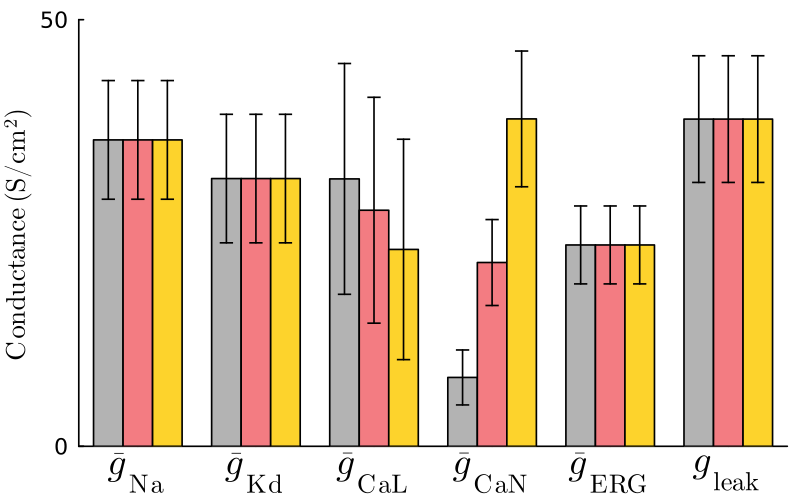

In [35]:
# Defining the number of conductances
nb_channels = 6

# Defining a matrix containing all conductances
g_all_bar = zeros(ncells, nb_channels*3)
scaling =  [1, 4, 700, 200, 200, 3000]
g_all_spiking_bar = g_all_spiking[1:end, 1:end .∉ [5]]
g_all_triplets_bar = g_all_triplets[1:end, 1:end .∉ [5]]
g_all_bursting_bar = g_all_bursting[1:end, 1:end .∉ [5]]
for i = 1 : nb_channels
    g_all_bar[:, (i-1)*3 + 1] = g_all_spiking_bar[:, i] .* scaling[i]
    g_all_bar[:, (i-1)*3 + 2] = g_all_triplets_bar[:, i] .* scaling[i]
    g_all_bar[:, (i-1)*3 + 3] = g_all_bursting_bar[:, i] .* scaling[i]
end

p4a = bar([1:4:21], mean(g_all_bar[:, 1:3:16], dims=1)', label="", grid=false, yguidefontsize=18, 
          color=:gray70, ytickfontsize=15, xguidefontsize=15, legendfontsize=12, 
          margin=3Plots.mm, yticks=[0, 50],  xrotation=0, xticks=false, 
          yerror=std(g_all_bar[:, 1:3:16], dims=1)', bar_width=1, ylabel=L"\mathrm{Conductance}\,\,\mathrm{(S/cm^2)}")

bar!([2:4:22], mean(g_all_bar[:, 2:3:17], dims=1)', label="", grid=false, yguidefontsize=18, 
     color=mySalmon, ytickfontsize=15, xguidefontsize=15, legendfontsize=12, 
     margin=3Plots.mm, yticks=[0, 50],  xrotation=0, xticks=false, 
     yerror=std(g_all_bar[:, 2:3:17], dims=1)', bar_width=1)

bar!([3:4:23], mean(g_all_bar[:, 3:3:18], dims=1)', label="", grid=false, yguidefontsize=18, 
     color=myYellow, ytickfontsize=15, xguidefontsize=15, legendfontsize=12, xtickfontsize=25,
     margin=3Plots.mm, yticks=[0, 50],  xrotation=0, yerror=std(g_all_bar[:, 3:3:18], dims=1)', 
     bar_width=1, xticks=(2:4:22, [L"\bar{g}_\mathrm{Na}", L"\bar{g}_\mathrm{Kd}", L"\bar{g}_\mathrm{CaL}", 
                                   L"\bar{g}_\mathrm{CaN}", L"\bar{g}_\mathrm{ERG}", L"g_\mathrm{leak}"]))

xlims!((0., 24.))
ylims!((0, 50))

p7a = plot(p4a, layout=(1, 1), legend=false, size=(807,500, 300))
display(p7a)
# savefig(p7a, "./figures/neuromod_gCaLCaN_gbar.pdf")

In [36]:
g_all_triplets_wout_NMDA = zeros(ncells, nb_channels)
g_all_bursting_wout_NMDA = zeros(ncells, nb_channels)

# Removing NMDA channels from the PCA analysis since it is constant
j = 1
for i in [1, 2, 3, 4, 5, 7]
    g_all_triplets_wout_NMDA[:, j] = deepcopy(g_all_triplets[:, i])
    g_all_bursting_wout_NMDA[:, j] = deepcopy(g_all_bursting[:, i])
    j = j + 1
end

# Means on triplets point cloud
mean_triplets = zeros(1, nb_channels)
mean!(mean_triplets, g_all_triplets_wout_NMDA)

# Means on bursting point cloud
mean_bursting = zeros(1, nb_channels)
mean!(mean_bursting, g_all_bursting_wout_NMDA)

# Defining scaling factors for the plots
s1 = 2
s2 = 2

# Normalizing data before applying PCA
g_all_triplets_norm = deepcopy(g_all_triplets_wout_NMDA)
for i = 1 : nb_channels
    g_all_triplets_norm[:, i] = g_all_triplets_wout_NMDA[:, i] / std(g_all_triplets_wout_NMDA[:, i])
end

g_all_bursting_norm = deepcopy(g_all_bursting_wout_NMDA)
for i = 1 : nb_channels
    g_all_bursting_norm[:, i] = g_all_bursting_wout_NMDA[:, i] / std(g_all_bursting_wout_NMDA[:, i])
end

# PCA on triplets point cloud
cov_matrix_triplets = cov(g_all_triplets_norm)
eig_triplets = eigen(cov_matrix_triplets, sortby = x -> abs(x))

# PCA on bursting point cloud
cov_matrix_bursting = cov(g_all_bursting_norm)
eig_bursting = eigen(cov_matrix_bursting, sortby = x -> abs(x))

eig_triplets_plot = deepcopy(eig_triplets)
for i = 1 : nb_channels
    eig_triplets_plot.vectors[i, :] = eig_triplets_plot.vectors[i, :] *
                                        std(g_all_triplets_wout_NMDA[:, i])
end

eig_bursting_plot = deepcopy(eig_bursting)
for i = 1 : nb_channels
    eig_bursting_plot.vectors[i, :] = eig_bursting_plot.vectors[i, :] *
                                        std(g_all_bursting_wout_NMDA[:, i])
end

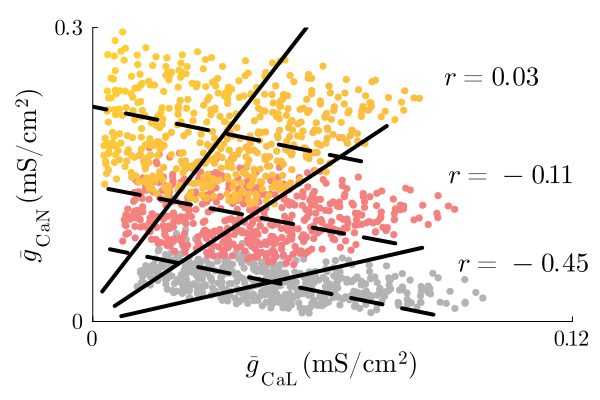

In [37]:
p7b = scatter(g_all_spiking[:, 3], g_all_spiking[:, 4], label="", grid=false, yguidefontsize=18, xguidefontsize=18, 
              margin=5Plots.mm, legend=false, color=:gray70, tickfontsize=15,
              colorbar_titlefontsize=18, markerstrokewidth=0., size=(600, 400), 
              xticks=([0, 0.12], [L"0", L"0.12"]), yticks=([0, 0.3], [L"0", L"0.3"]))
scatter!(g_all_triplets[:, 3], g_all_triplets[:, 4], label="", zcolor=burstiness_triplets, 
         c=cgrad(mycmap, rev=false), markerstrokewidth=0.)
scatter!(g_all_bursting[:, 3], g_all_bursting[:, 4], label="", zcolor=burstiness_bursting,
         c=cgrad(mycmap, rev=false), markerstrokewidth=0.)

plot!([mean_spiking[3] - s1*eig_spiking_plot.vectors[:, nb_channels][3]*eig_spiking_plot.values[nb_channels], 
       mean_spiking[3] + s1*eig_spiking_plot.vectors[:, nb_channels][3]*eig_spiking_plot.values[nb_channels]],
       [mean_spiking[4] - s1*eig_spiking_plot.vectors[:, nb_channels][4]*eig_spiking_plot.values[nb_channels], 
       mean_spiking[4] + s1*eig_spiking_plot.vectors[:, nb_channels][4]*eig_spiking_plot.values[nb_channels]],
       arrow=false, color=:black, linewidth=4, label="", linestyle=:solid)

plot!([mean_spiking[3] - s2*eig_spiking_plot.vectors[:, nb_channels-1][3]*eig_spiking_plot.values[nb_channels-1], 
       mean_spiking[3] + s2*eig_spiking_plot.vectors[:, nb_channels-1][3]*eig_spiking_plot.values[nb_channels-1]],
       [mean_spiking[4] - s2*eig_spiking_plot.vectors[:, nb_channels-1][4]*eig_spiking_plot.values[nb_channels-1], 
       mean_spiking[4] + s2*eig_spiking_plot.vectors[:, nb_channels-1][4]*eig_spiking_plot.values[nb_channels-1]],
       arrow=false, color=:black, linewidth=4, label="", linestyle=:dash)

plot!([mean_triplets[3] - s1*eig_triplets_plot.vectors[:, nb_channels][3]*eig_triplets_plot.values[nb_channels], 
       mean_triplets[3] + s1*eig_triplets_plot.vectors[:, nb_channels][3]*eig_triplets_plot.values[nb_channels]],
       [mean_triplets[4] - s1*eig_triplets_plot.vectors[:, nb_channels][4]*eig_triplets_plot.values[nb_channels], 
       mean_triplets[4] + s1*eig_triplets_plot.vectors[:, nb_channels][4]*eig_triplets_plot.values[nb_channels]],
       arrow=false, color=:black, linewidth=4, label="", linestyle=:solid)

plot!([mean_triplets[3] - s2*eig_triplets_plot.vectors[:, nb_channels-1][3]*eig_triplets_plot.values[nb_channels-1], 
       mean_triplets[3] + s2*eig_triplets_plot.vectors[:, nb_channels-1][3]*eig_triplets_plot.values[nb_channels-1]],
       [mean_triplets[4] - s2*eig_triplets_plot.vectors[:, nb_channels-1][4]*eig_triplets_plot.values[nb_channels-1], 
       mean_triplets[4] + s2*eig_triplets_plot.vectors[:, nb_channels-1][4]*eig_triplets_plot.values[nb_channels-1]],
       arrow=false, color=:black, linewidth=4, label="", linestyle=:dash)

plot!([mean_bursting[3] - s1*eig_bursting_plot.vectors[:, nb_channels][3]*eig_bursting_plot.values[nb_channels], 
       mean_bursting[3] + s1*eig_bursting_plot.vectors[:, nb_channels][3]*eig_bursting_plot.values[nb_channels]],
       [mean_bursting[4] - s1*eig_bursting_plot.vectors[:, nb_channels][4]*eig_bursting_plot.values[nb_channels], 
       mean_bursting[4] + s1*eig_bursting_plot.vectors[:, nb_channels][4]*eig_bursting_plot.values[nb_channels]],
       arrow=false, color=:black, linewidth=4, label="", linestyle=:solid)

plot!([mean_bursting[3] - s2*eig_bursting_plot.vectors[:, nb_channels-1][3]*eig_bursting_plot.values[nb_channels-1], 
       mean_bursting[3] + s2*eig_bursting_plot.vectors[:, nb_channels-1][3]*eig_bursting_plot.values[nb_channels-1]],
       [mean_bursting[4] - s2*eig_bursting_plot.vectors[:, nb_channels-1][4]*eig_bursting_plot.values[nb_channels-1], 
       mean_bursting[4] + s2*eig_bursting_plot.vectors[:, nb_channels-1][4]*eig_bursting_plot.values[nb_channels-1]],
       arrow=false, color=:black, linewidth=4, label="", linestyle=:dash)

pearson_cor_spiking = cor(g_all_spiking[:, 3], g_all_spiking[:, 4])
str_pearson_cor_spiking = @sprintf "%.2f" pearson_cor_spiking
annotate!(0.108, 0.06, Plots.text(L"r =  %$str_pearson_cor_spiking", :black, :center, 18))

pearson_cor_triplets = cor(g_all_triplets[:, 3], g_all_triplets[:, 4])
str_pearson_cor_triplets = @sprintf "%.2f" pearson_cor_triplets
annotate!(0.105, 0.15, Plots.text(L"r =  %$str_pearson_cor_triplets", :black, :center, 18))

pearson_cor_bursting = cor(g_all_bursting[:, 3], g_all_bursting[:, 4])
str_pearson_cor_bursting = @sprintf "%.2f" pearson_cor_bursting
annotate!(0.1, 0.25, Plots.text(L"r =  %$str_pearson_cor_bursting", :black, :center, 18))

xlabel!(L"\bar{g}_\mathrm{CaL}\,\mathrm{(mS/cm^2)}")
ylabel!(L"\bar{g}_\mathrm{CaN}\,\mathrm{(mS/cm^2)}")
xlims!((0, 0.12))
ylims!((0, 0.3))
display(p7b)
# savefig(p7b, "./figures/PCA_DA_neuromod_gCaLCaN_burstiness.pdf")

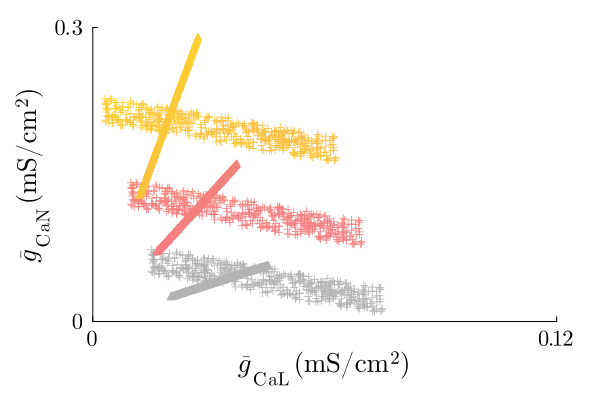

In [38]:
p7c = scatter(g_all_spiking_DIC[:, 3], g_all_spiking_DIC[:, 4], label="", legend=false,
              markershape=:cross, color=:gray70, grid=false, yguidefontsize=18, 
              xguidefontsize=18, legendfontsize=12, margin=5Plots.mm,
              colorbar_title="burstiness", tickfontsize=15,
              colorbar_titlefontsize=18, size=(600, 400), 
              xticks=([0, 0.12], [L"0", L"0.12"]), yticks=([0, 0.3], [L"0", L"0.3"]))
scatter!(g_all_spiking_leak[:, 3], g_all_spiking_leak[:, 4], label="", 
         color=:gray70, markershape=:utriangle, markerstrokewidth=0.)
scatter!(g_all_triplets_DIC[:, 3], g_all_triplets_DIC[:, 4], label="", markershape=:cross,
         zcolor=burstiness_triplets_DIC, c=cgrad(mycmap, rev=false))
scatter!(g_all_triplets_leak[:, 3], g_all_triplets_leak[:, 4], label="", markerstrokewidth=0.,
         markershape=:utriangle, zcolor=burstiness_triplets_leak, c=cgrad(mycmap, rev=false))
scatter!(g_all_bursting_DIC[:, 3], g_all_bursting_DIC[:, 4], label="",
         markershape=:cross, zcolor=burstiness_bursting_DIC, c=cgrad(mycmap, rev=false))
scatter!(g_all_bursting_leak[:, 3], g_all_bursting_leak[:, 4], label="", markerstrokewidth=0.,
         markershape=:utriangle, zcolor=burstiness_bursting_leak, c=cgrad(mycmap, rev=false))

xlabel!(L"\bar{g}_\mathrm{CaL}\,\mathrm{(mS/cm^2)}")
ylabel!(L"\bar{g}_\mathrm{CaN}\,\mathrm{(mS/cm^2)}")
xlims!((0, 0.12))
ylims!((0, 0.3))
display(p7c)
# savefig(p7c, "./figures/neuromod_gCaLCaN_separation_burstiness.pdf")

# **Neuromodulation paths can arise from simple rule, but not as simple as purely additive or multiplicative (Figure 8)**

In [39]:
burstiness = readdlm("./data/burstiness_paths.dat")
g_all_init = readdlm("./data/g_all_init_paths.dat")
gCaLs = readdlm("./data/gCaLs_paths.dat")
gCaNs = readdlm("./data/gCaNs_paths.dat");

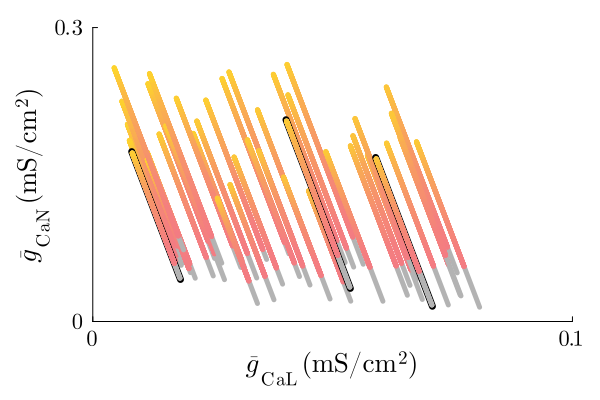

In [40]:
# Initializing some variables
n = size(gCaNs)[2]

# Picking first path randomly
Random.seed!(292)
j1 = Int(ceil(rand(1, 1)[1] * n))

# Picking second path randomly
Random.seed!(554)
j2 = Int(ceil(rand(1, 1)[1] * n))

# Picking third path randomly
Random.seed!(442)
j3 = Int(ceil(rand(1, 1)[1] * n))

# Plotting the results
p8a = plot(legend=false, tickfontsize=15, colorbar_titlefontsize=18, size=(600, 400), markerstrokewidth=0.,
           xticks=([0, 0.1], [L"0", L"0.1"]), yticks=([0, 0.3], [L"0", L"0.3"]))

# Looping over all neurons
for j = 1 : n
    # Plotting first spiking neurons
    i_thresh = minimum(findall(burstiness[:, j] .> 0))
    if i_thresh > 1
        plot!(gCaLs[1:i_thresh, j], gCaNs[1:i_thresh, j], label="", grid=false, linewidth=5, 
              yguidefontsize=18, xguidefontsize=18, margin=5Plots.mm, color=:gray70)
    end
    
    # Then plotting bursting neurons
    plot!(gCaLs[i_thresh:end, j], gCaNs[i_thresh:end, j], label="", 
          line_z=burstiness[i_thresh:end, j], grid=false, linewidth=5, clim=(50, 500),
          yguidefontsize=18, xguidefontsize=18, margin=5Plots.mm, c=cgrad(mycmap, rev=false))
end

# Plotting special paths
for j in [j1, j2, j3]
    # Add a black frame to the path
    line_CaLCaN = fit(gCaLs[:, j], gCaNs[:, j], 1)
    start_x = minimum(gCaLs[:, j]) - 0.0001
    end_x = maximum(gCaLs[:, j]) + 0.0001
    plot!([start_x, end_x], [line_CaLCaN(start_x), line_CaLCaN(end_x)], 
          label="", grid=false, linewidth=7, yguidefontsize=18, 
          xguidefontsize=18, margin=5Plots.mm, color=:black)

    plot!(gCaLs[:, j], gCaNs[:, j], label="", grid=false, linewidth=5, 
          yguidefontsize=18, xguidefontsize=18, margin=5Plots.mm, color=:white)
    
    # Plotting first spiking neurons
    i_thresh = minimum(findall(burstiness[:, j] .> 0))
    if i_thresh > 1
        plot!(gCaLs[1:i_thresh, j], gCaNs[1:i_thresh, j], label="", grid=false, linewidth=5, 
              yguidefontsize=18, xguidefontsize=18, margin=5Plots.mm, color=:gray70)
    end
    
    # Then plotting bursting neurons
    plot!(gCaLs[i_thresh:end, j], gCaNs[i_thresh:end, j], label="", 
          line_z=burstiness[i_thresh:end, j], grid=false, linewidth=5, clim=(50, 500),
          yguidefontsize=18, xguidefontsize=18, margin=5Plots.mm, c=cgrad(mycmap, rev=false))
end

xlabel!(L"\bar{g}_\mathrm{CaL}\,\mathrm{(mS/cm^2)}")
ylabel!(L"\bar{g}_\mathrm{CaN}\,\mathrm{(mS/cm^2)}")
xlims!((0, 0.1))
ylims!((0, 0.3))
display(p8a)
# savefig(p8a, "./figures/neuromod_gCaLCaN_paths.pdf")

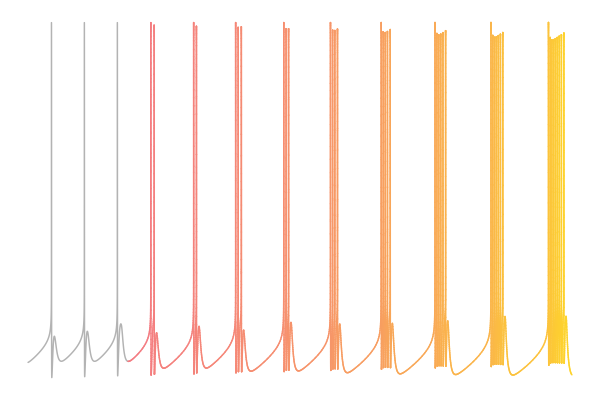

In [41]:
# Computing the regression line along the neuromodulation path
line_CaLCaN = fit(gCaLs[:, j1], gCaNs[:, j1], 1)
a0 = line_CaLCaN[0]
a1 = line_CaLCaN[1]
gCaL_min = minimum(gCaLs[:, j1])
gCaL_max = maximum(gCaLs[:, j1])

# Extracting the maximal ion channel conductances
(gNa, gKd, _, _, gERG, gNMDA, gleak) = g_all_init[j1, :]

# Parameter vector for simulations
p = [0., gNa, gKd, gCaL_min, gCaL_max, gERG, gNMDA, gleak, C, a0, a1]

# Initial conditions
V0 = -90.
x0 = [V0, m_inf(V0), h_inf(V0), n_inf(V0), mCaL_inf(V0), mCaN_inf(V0), 0., 0.]

# Simulation
prob = ODEProblem(DA_ODE_neuromod, x0, tspan, p)
sol = solve(prob, verbose=false)

# Removing transient part
V_t = sol[1, :][320:end-150]
t = sol.t[320:end-150]
p8b = plot(t[1:545], V_t[1:545], linewidth=1.5, grid=false, xticks=[], yticks=[], color=:gray70, 
           yguidefontsize=18, xguidefontsize=18, legend=false, axis=false)
plot!(t[545:end], V_t[545:end], linewidth=1.5, grid=false, xticks=[], yticks=[], 
      line_z=range(0, 500, length(t[545:end])), c=cgrad(mycmap, rev=false), yguidefontsize=18, 
      xguidefontsize=18, legend=false, axis=false)
display(p8b)
# savefig(p8b, "./figures/neuromod_gCaLCaN_path_simu1.pdf")

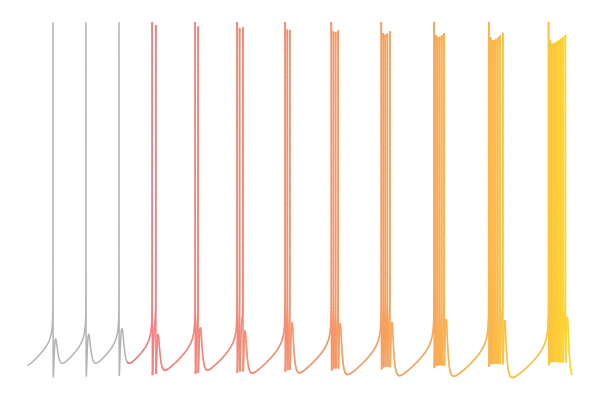

In [42]:
# Computing the regression line along the neuromodulation path
line_CaLCaN = fit(gCaLs[:, j2], gCaNs[:, j2], 1)
a0 = line_CaLCaN[0]
a1 = line_CaLCaN[1]
gCaL_min = minimum(gCaLs[:, j2])
gCaL_max = maximum(gCaLs[:, j2])

# Extracting the maximal ion channel conductances
(gNa, gKd, _, _, gERG, gNMDA, gleak) = g_all_init[j2, :]

# Parameter vector for simulations
p = [0., gNa, gKd, gCaL_min, gCaL_max, gERG, gNMDA, gleak, C, a0, a1]

# Initial conditions
V0 = -90.
x0 = [V0, m_inf(V0), h_inf(V0), n_inf(V0), mCaL_inf(V0), mCaN_inf(V0), 0., 0.]

# Simulation
prob = ODEProblem(DA_ODE_neuromod, x0, tspan, p)
sol = solve(prob, verbose=false)

# Removing transient part
V_t = sol[1, :][320:end-20]
t = sol.t[320:end-20]
p8c = plot(t[1:530], V_t[1:530], linewidth=1.5, grid=false, xticks=[], yticks=[], color=:gray70, 
           yguidefontsize=18, xguidefontsize=18, legend=false, axis=false)
plot!(t[530:end], V_t[530:end], linewidth=1.5, grid=false, xticks=[], yticks=[], 
      line_z=range(0, 500, length(t[530:end])), c=cgrad(mycmap, rev=false), yguidefontsize=18, 
      xguidefontsize=18, legend=false, axis=false)
display(p8c)
# savefig(p8c, "./figures/neuromod_gCaLCaN_path_simu2.pdf")

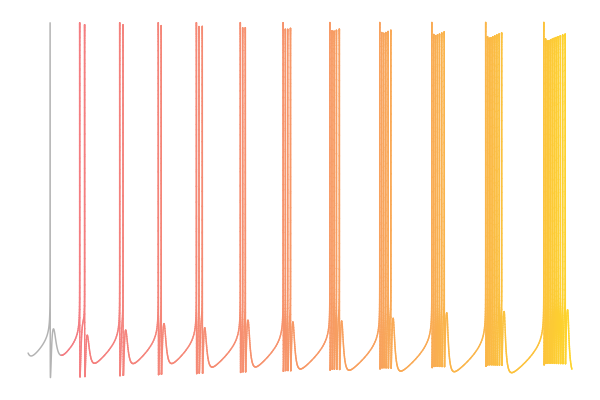

In [43]:
# Definition of simulation time (in ms)
const Tfinal = 10200
const tspan  = (0.0, Tfinal)

# Need of reloading the DA model
include("FYON_2022_DA_models.jl")

# Computing the regression line along the neuromodulation path
line_CaLCaN = fit(gCaLs[:, j3], gCaNs[:, j3], 1)
a0 = line_CaLCaN[0]
a1 = line_CaLCaN[1]
gCaL_min = minimum(gCaLs[:, j3])
gCaL_max = maximum(gCaLs[:, j3])

# Extracting the maximal ion channel conductances
(gNa, gKd, _, _, gERG, gNMDA, gleak) = g_all_init[j3, :]

# Parameter vector for simulations
p = [0., gNa, gKd, gCaL_min, gCaL_max, gERG, gNMDA, gleak, C, a0, a1]

# Initial conditions
V0 = -90.
x0 = [V0, m_inf(V0), h_inf(V0), n_inf(V0), mCaL_inf(V0), mCaN_inf(V0), 0., 0.]

# Simulation
prob = ODEProblem(DA_ODE_neuromod, x0, tspan, p)
sol = solve(prob, verbose=false)

# Removing transient part
V_t = sol[1, :][320:end]
t = sol.t[320:end]
p8d = plot(t[1:185], V_t[1:185], linewidth=1.5, grid=false, xticks=[], yticks=[], color=:gray70, 
           yguidefontsize=18, xguidefontsize=18, legend=false, axis=false)
plot!(t[185:end], V_t[185:end], linewidth=1.5, grid=false, xticks=[], yticks=[], 
      line_z=range(0, 500, length(t[185:end])), c=cgrad(mycmap, rev=false), yguidefontsize=18, 
      xguidefontsize=18, legend=false, axis=false)
display(p8d)
# savefig(p8d, "./figures/neuromod_gCaLCaN_path_simu3.pdf")

# **Supplementary figures**

## **Figure S1**

In [44]:
# Initializing some variables
freq = zeros(ncells)

@showprogress 1 "Computing..." for i = 1 : ncells
    # Retrieving maximal conductances from what had been computed
    (gNa, gKd, gCaL, gCaN, gERG, gNMDA, gleak) = g_all_spiking[i, :]

    # Parameter vector for simulations
    p = [0., gNa, gKd, gCaL, gCaN, gERG, gNMDA, gleak, C]

    # Initial conditions
    V0 = -90.
    x0 = [V0, m_inf(V0), h_inf(V0), n_inf(V0), mCaL_inf(V0), mCaN_inf(V0), 0., 0.]

    # Simulation
    prob = ODEProblem(DA_ODE, x0, tspan, p) # Describing the problem
    sol = solve(prob, saveat=0.1) # Solving the problem

    # Saving results
    VV = sol[1, 50001:end]
    tt = sol.t[50001:end]

    # Computing spiking frequency
    if tt[end] != Tfinal
        freq[i] = 0.
    else
        freq[i] = extract_frequency(VV, tt)
        if isnan(freq[i])
            freq[k, i] = 0.
        end
    end
end

Computing... 100%|███████████████████████████████████████| Time: 0:00:32


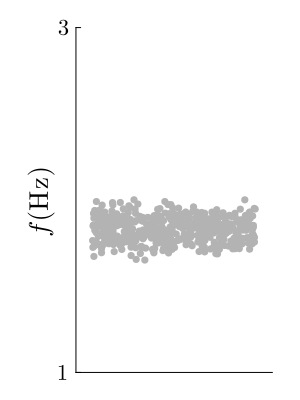

In [45]:
Random.seed!(2022)
pS = scatter(rand(ncells), freq, label="", color=:gray70, grid=false,
              yguidefontsize=18, xguidefontsize=18, legendfontsize=12, margin=5Plots.mm,
              markerstrokewidth=0., yticks=([1, 3], [L"1", L"3"]), tickfontsize=15, 
              xticks=false, size=(300, 400))

ylabel!(L"f\,\mathrm{(Hz)}")
xlims!((-0.1, 1.1))
ylims!((1, 3))
display(pS)
# savefig(pS, "./figures/DA_freq_spiking.pdf")